In [1]:
# common imports
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import joblib, glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn import clone  # 'clone' constructs a new unfitted estimator with the same parameters

# display setup
pd.set_option("display.max_columns", None)  # the None parameter displays unlimited columns
plt.style.use('seaborn')  # for plots

# Preface
* The hand movements data contains 12 different participants, 9 for training set and 3 for the test set.
* Each person has 3 csv files with recorded hand movements, one for each of the three states.
* The three states are: Alone, Spontaneous and Sync.
> * Alone:
> * Spontaneous:
> * Sync:
* The predicted labels are the states, making this a **multiclass classification** problem and a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore, also known as **offline/batch learning**.
* Main objective: Find the best algorithm and model parameters that correctly predict the state of the hand movements.

# 1. Getting the Data

> Each participant has 3 csv files, one for each alignment state.

> Taking a look at a file should help gain insight to which DataFrame manipulations need to be implemented
> in the functions that will load the whole dataset.
>
> The 'HandRight' file contains right-hand movements which needs to be merged with the 'Alone' state files.
> Preparing it beforehand is more efficient since it will be used multiple times when loading the data.

In [2]:
# read right hand file
handright = pd.read_csv(r"extraFiles/HandRight.csv")

In [3]:
# display first 5 rows for a quick look
handright.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.67167,226.2064,20.26470,34.26665,-195.214700,-35.043020,0.270987,-0.017635,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.24119,222.9389,20.11781,36.16443,-180.093900,-4.052799,0.245085,-0.014770,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.72461,220.9709,19.94972,26.35298,-95.088190,-11.157620,0.230796,-0.008779,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.09016,219.7124,19.67679,19.46804,-61.755180,-21.303780,0.217681,-0.010759,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.46017,219.3652,19.13128,21.94964,-8.355943,-35.081790,0.220696,-0.017380,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0


In [4]:
# DataFrame shape (rows, columns)
handright.shape

(4812, 22)

In [5]:
# description of data
handright.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4812 non-null   float64
 1    Frame ID        4812 non-null   int64  
 2    Hand Type       4812 non-null   object 
 3    # hands         4812 non-null   int64  
 4    Position X      4812 non-null   float64
 5    Position Y      4812 non-null   float64
 6    Position Z      4812 non-null   float64
 7    Velocity X      4812 non-null   float64
 8    Velocity Y      4812 non-null   float64
 9    Velocity Z      4812 non-null   float64
 10   Pitch           4812 non-null   float64
 11   Roll            4812 non-null   float64
 12   Yaw             4812 non-null   float64
 13   Wrist Pos X     4428 non-null   float64
 14   Wrist Pos Y     4428 non-null   float64
 15   Wrist Pos Z     4428 non-null   float64
 16   Elbow pos X     4428 non-null   float64
 17   Elbow Pos Y  

In [6]:
# show null values
handright.isna().sum()

Time                 0
 Frame ID            0
 Hand Type           0
 # hands             0
 Position X          0
 Position Y          0
 Position Z          0
 Velocity X          0
 Velocity Y          0
 Velocity Z          0
 Pitch               0
 Roll                0
 Yaw                 0
 Wrist Pos X       384
 Wrist Pos Y       384
 Wrist Pos Z       384
 Elbow pos X       384
 Elbow Pos Y       384
 Elbow Pos Z       384
 Grab Strenth        0
 Grab Angle          0
 Pinch Strength      0
dtype: int64

In [7]:
# should only contain 1 hand instances
handright[" # hands"].value_counts()

1    4732
2      80
Name:  # hands, dtype: int64

In [8]:
# should only contain right hand instances
handright[" Hand Type"].value_counts()

right    4738
left       74
Name:  Hand Type, dtype: int64

> Features in the DataFrame:
1. Time: Second and milliseconds of recorded movement
2. Frame ID: Frame number of detected movement
3. Hand Type: Right or left hand
4. Number hands: Hands detected in the frame/movement
5. Position (X, Y, Z): Center position of the palm from the leap origin (in millimeters)
6. Velocity (X, Y, Z): Rate of change of the palm position (millimeters per second)
7. Pitch: The rotation around the x-axis (angle above or below the x-z plane in radians)
8. Roll: The rotation around the z-axis (angle right or left of the y-axis in radians)
9. Yaw: The rotation around the y-axis (angle right or left of the y-axis in radians)
10. Wrist Pos (X, Y, Z): Position of the wrist
11. Elbow pos (X, Y, Z): Position of the elbow
12. Grab Strength: The strength of a grab hand pose (values in range [0,1])
** Grab strength deprecated from version 2.0, use grab angle instead
13. Grab Angle: The angle between the fingers and the grab hand pose (0 to pi radians)
14. Pinch Strength: Pinch holding strength between the thumb and closest fingertip
(0 = flat open hand, (0, 1] = pinch strength increases as the tip of thumb approaches fingertip).

* X, Y, Z represent leap motion controller coordinates (see image below).

> Features in the DataFrame:
1. Time: Second and milliseconds of recorded movement
2. Frame ID: ID of the frame the hand belongs to
3. Hand Type: Right or left hand
4. Number hands: Hands detected in the frame/movement
5. Position (X, Y, Z): Center position of the palm from the leap origin (in millimeters)
6. Velocity (X, Y, Z): Rate of change of the palm position (millimeters per second)
7. Pitch: The rotation around the x-axis (angle above or below the x-z plane in radians)
8. Roll: The rotation around the z-axis (angle right or left of the y-axis in radians)
9. Yaw: The rotation around the y-axis (angle right or left of the y-axis in radians)
10. Wrist Pos (X, Y, Z): Position of the wrist
11. Elbow pos (X, Y, Z): Position of the elbow
12. Grab Strength: The grab posture rating of the hand
13. Grab Angle: The average angle of the fingers to the hand
14. Pinch Strength: Pinch holding strength between the thumb and closest fingertip
(0 = flat open hand, (0, 1] = pinch strength increases as the tip of thumb approaches fingertip).

* X, Y, Z represent leap motion controller coordinates (see image below).

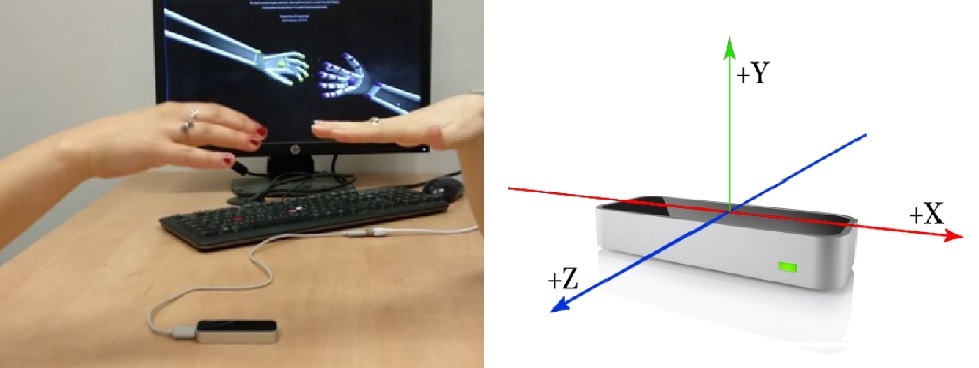

In [9]:
from IPython import display
display.Image("extraFiles/leap.jpg")

Clearly just by looking at a few files the data needs to be cleaned.

* Alone has instances with 2 hands and right hand in hand type that need to be removed. Likewise, spontaneous
and sync have instances with 1 hand and a mismatch between right and left hands.

In [10]:
def remove_first7(df):
    df.drop(df[df["Time"] < df["Time"].min() + 7].index, inplace=True)
    # drop is True to prevent from adding the old indices as a new column
    df.reset_index(drop=True, inplace=True)

In [11]:
print("Before:", handright.shape)
handright_prepared = handright.drop(handright[(handright[" Hand Type"] == "left") | (handright[" # hands"] == 2)].index)
handright_prepared.reset_index(drop=True, inplace=True)
remove_first7(handright_prepared)  # right hand file without first 7 seconds

Before: (4812, 22)


In [12]:
print("Null values:", handright_prepared.isna().sum().sum())
handright_prepared[handright_prepared.isna().any(axis=1)].head()

Null values: 2304


,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
3893,201.8797,23959,right,1,-8.565041,140.3621,112.05200,32.42480,-145.06130,-160.3878,1.188079,-2.793904,-0.139680,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.0
3894,201.8968,23962,right,1,1.858126,112.7275,95.47443,497.33780,-642.50110,-686.8898,0.144945,0.010979,0.038722,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.418411,0.0
3895,201.9134,23963,right,1,2.825271,112.5456,91.11944,112.62890,-21.18921,-507.1606,0.143836,-0.002969,0.067269,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.379807,0.0
3896,201.9300,23965,right,1,3.694190,113.4331,82.37254,61.92186,95.66204,-499.7987,0.157899,-0.025162,0.093537,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.523864,0.0
3897,201.9464,23967,right,1,5.272612,115.7207,73.13319,107.58490,139.81950,-569.6603,0.149520,-0.008641,0.075155,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.715370,0.0


In [13]:
handright_prepared.dropna(inplace=True)
print("Null values:", handright_prepared.isna().sum().sum())
print("After:", handright_prepared.shape)
handright_prepared.head()

Null values: 0
After: (3893, 22)


,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.3466,-57.68153,-0.092033,0.108262,-0.906612,75.45740,206.0521,45.38764,284.3946,140.0167,201.9318,0.0,0.561324,0.0
1,135.3194,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.8374,-77.18515,-0.111674,0.126925,-0.904311,74.46141,202.4562,44.28679,282.6278,140.9712,203.6773,0.0,0.626321,0.0
2,135.3357,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.0033,-43.79815,-0.140004,0.127219,-0.901862,73.60060,197.4387,43.54082,280.6384,142.5401,206.7526,0.0,0.636596,0.0
3,135.3524,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.2120,-43.99948,-0.166623,0.122782,-0.901268,73.19537,191.7202,42.73155,279.7357,148.1382,209.9330,0.0,0.701644,0.0
4,135.3690,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.4513,-53.88054,-0.197763,0.127587,-0.897777,72.68671,186.1613,41.98006,278.6890,152.5215,212.1112,0.0,0.786548,0.0


> The following functions load the data into a DataFrame:

In [14]:
# function combines alone csv file with the right hand file

def combine_right(df_alone):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand prevents harming the DataFrame since it is used multiple times
    right = handright_prepared.copy()

    # calculate number of copies needed to match length of left hand
    n_copies = round(len(df_alone) / len(right)) + 1
    copies = []  # list for appending copies
    for i in range(n_copies):
        copies.append(right)
    right = pd.concat(copies, axis=0, ignore_index=True)  # concat DataFrame copies
    right = right.loc[:len(df_alone) - 1]  # -1 since loc includes the end index and dataframe indices start from 0

    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

In [15]:
# function returns a DataFrame with right and left hands merged into one row
# column names format is changed

def transform_columns(df):
    # strip removes white spaces in the beginning and end
    # lower changes uppercase letters to lowercase
    df.columns = df.columns.str.strip().str.lower()
    # rename columns without spaces
    df.columns = df.columns.str.replace(" ", "_")
    # change number of hands column name
    df.columns = df.columns.str.replace("#_hands", "n_hands")
    df.columns = df.columns.str.replace("grab_strenth", "grab_strength")

    # remove instances with 1 hand detected
    df.drop(df[df["n_hands"] == 1].index, inplace=True)

    # merge right and left hands into one row
    left = df.groupby("hand_type").get_group("left").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    right = df.groupby("hand_type").get_group("right").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    keep_same = {"state", "time"}  # shared columns
    left.columns = left.columns.map(lambda x: x if x in keep_same else x + "_left")
    right.columns = right.columns.map(lambda x: x if x in keep_same else x + "_right")
    merged = left.merge(right, how="outer", on=["state", "time"])
    # adds a column with the second
#    merged.insert(1, "round_time", merged.time.astype(int) - merged.time.min().astype(int))
    merged.insert(1, "round_time", merged.time.round(1))
    # return first frame per rounded millisecond
    return merged.groupby("round_time").nth([0]).reset_index(drop=True) # round time is the index after groupby

alone = pd.read_csv(r"extraFiles/Training/Evyatar Cohen/Evyatar636771054555711409Alone.csv")
alone_new = combine_right(alone)
alone_new.insert(1, "state", 0)
alone_newnew = transform_columns(alone_new)
alone_newnew

alone2 = pd.read_csv(r"extraFiles/Training/Yael Hagai/Yael636771061659067649Alone.csv")
alone2_new = combine_right(alone2)
alone2_new.insert(1, "state", 0)
alone2_newnew = transform_columns(alone2_new)
alone2_newnew

rightcols = alone_newnew.filter(regex="right").columns.tolist()
rightcols

alone_newnew

alone_newnew[rightcols]

alone2_newnew[rightcols]

> Rescaling the times in round time to start from zero rather than rounding the time values can create more diverse
> samples for each second. This is especially important for the 'alone' state, where the right hand is concatenated from
> the same file.

In [16]:
train_path = "extraFiles/Training/**/*.csv"
test_path = "extraFiles/Validation/**/*.csv"


def load_data(path, as_pandas):
    data = []
    # glob searches all directories and files
    for filename in glob.iglob(path, recursive=True):
        df = pd.read_csv(filename, index_col=None, header=0)
        remove_first7(df)  # removes first 7 seconds from file
        if "Alone" in filename:
            df = combine_right(df)
            df.insert(0, "state", 0)
        elif "Spontan" in filename:
            df.insert(0, "state", 1)
        elif "Sync" in filename:
            df.insert(0, "state", 2)
        df = transform_columns(df)
        data.append(df)
    if as_pandas:
        return pd.concat(data, axis=0, ignore_index=True)
    return data

In [17]:
# load the data
train_set = load_data(train_path, as_pandas=True)
test_set = load_data(test_path, as_pandas=True)

In [18]:
# display loaded data
train_set.head()

,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
0,1,343.0061,-102.2870,198.3166,-2.122641,-174.57210,379.14680,28.47991,1.423625,0.510471,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.715490,11.754400,0.000000,1.870325,0.0,152.3135,204.6813,-39.25671,-28.56766,23.00662,8.315823,0.654996,-0.130873,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.7099,1.000000,2.793122,0.329752
1,1,343.0558,-107.9509,212.1324,-2.788956,-74.28078,244.48230,-30.77130,1.444497,0.483316,1.499930,-170.1878,179.6781,-4.185746,-315.3597,-25.782140,-9.287997,0.000000,1.899355,0.0,151.6132,202.9217,-37.08601,21.48209,-21.23486,51.146260,0.608950,-0.142477,-0.548808,190.8024,170.2935,12.170700,323.0928,17.14600,161.7030,1.000000,2.101400,0.052777
2,1,343.1552,-114.6943,242.6570,-9.972559,-82.28933,386.41130,-114.18180,1.346878,0.382191,1.474913,-178.4730,214.4584,-12.161470,-300.8841,-2.874147,-45.280820,0.352719,1.681010,0.0,149.1118,200.5923,-41.04056,-82.82854,-98.02619,-46.982960,0.257712,-0.132038,-0.797368,204.2183,188.7925,1.579636,377.7471,70.59559,140.2593,0.226585,1.160870,0.000000
3,1,343.2546,-113.7012,265.1228,-18.019300,-29.71481,232.72690,-112.08070,1.487226,0.126440,1.560127,-181.4998,252.6608,-25.746330,-327.1140,49.860090,-57.101990,0.000000,0.987889,0.0,146.8970,192.2783,-41.28103,11.02877,-58.94086,18.482700,-0.307475,0.181103,-0.981201,206.5377,202.8605,-7.007293,363.4305,98.06007,159.4749,0.171141,1.188835,0.000000
4,1,343.3540,-113.0482,277.6174,-32.889070,-56.77644,88.37032,-159.83910,1.385760,0.089070,1.554326,-181.3927,267.2602,-40.110340,-340.6616,73.414570,-59.184880,0.000000,1.027158,0.0,148.4452,186.4893,-36.54840,17.48643,-59.21349,40.518680,-0.657814,0.356423,-0.992480,203.3546,211.4626,-3.244526,323.5683,147.69440,208.3891,0.132936,1.122186,0.000000


# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [19]:
hands = train_set.copy()

In [20]:
hands.head(2)

,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
0,1,343.0061,-102.2870,198.3166,-2.122641,-174.57210,379.1468,28.47991,1.423625,0.510471,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.0,152.3135,204.6813,-39.25671,-28.56766,23.00662,8.315823,0.654996,-0.130873,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.7099,1.0,2.793122,0.329752
1,1,343.0558,-107.9509,212.1324,-2.788956,-74.28078,244.4823,-30.77130,1.444497,0.483316,1.499930,-170.1878,179.6781,-4.185746,-315.3597,-25.78214,-9.287997,0.0,1.899355,0.0,151.6132,202.9217,-37.08601,21.48209,-21.23486,51.146260,0.608950,-0.142477,-0.548808,190.8024,170.2935,12.170700,323.0928,17.14600,161.7030,1.0,2.101400,0.052777


In [21]:
hands.shape

(17978, 38)

In [22]:
# check if time and state are related
hands.sort_values("time").loc[800:850, ["state", "time"]]

,state,time
800,2,446.0507
10623,1,446.0511
2572,1,446.0523
15822,0,446.0530
7409,1,446.0590
...,...,...
849,2,450.9545
10672,1,450.9556
2621,1,450.9560
15871,0,450.9567


In [23]:
hands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17978 entries, 0 to 17977
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 17978 non-null  int64  
 1   time                  17978 non-null  float64
 2   position_x_left       17978 non-null  float64
 3   position_y_left       17978 non-null  float64
 4   position_z_left       17978 non-null  float64
 5   velocity_x_left       17978 non-null  float64
 6   velocity_y_left       17978 non-null  float64
 7   velocity_z_left       17978 non-null  float64
 8   pitch_left            17978 non-null  float64
 9   roll_left             17978 non-null  float64
 10  yaw_left              17978 non-null  float64
 11  wrist_pos_x_left      17978 non-null  float64
 12  wrist_pos_y_left      17978 non-null  float64
 13  wrist_pos_z_left      17978 non-null  float64
 14  elbow_pos_x_left      17978 non-null  float64
 15  elbow_pos_y_left   

In [24]:
# check for null values
hands.isna().sum().sum()

0

In [25]:
# summary of the numerical attributes
# null values are ignored
hands.describe()

,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
count,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000,17978.000000
mean,1.001112,541.282002,-107.996139,204.082799,32.048357,0.390505,-1.124648,0.319637,0.997469,0.763721,1.104577,-149.672590,165.297734,40.727487,-313.920150,5.424821,75.593177,0.118367,0.823393,0.193260,93.365263,214.378646,39.235362,-0.201024,-2.117126,0.255000,0.809833,-0.641228,-0.673652,125.017661,175.612052,73.578420,266.730579,25.583976,187.376926,0.068314,0.522589,0.058266
std,0.816201,143.794344,51.628266,53.110893,55.018436,137.279973,210.024732,130.566674,0.932909,1.103222,0.853881,47.911520,48.895103,47.720811,60.683932,70.072518,65.492353,0.284849,0.922073,0.336543,65.194435,54.271723,54.668882,159.299906,265.783405,182.863568,0.604698,0.673325,0.623281,73.300380,49.621628,54.955406,98.066489,62.112981,102.428463,0.221469,0.696122,0.199859
min,0.000000,182.549200,-332.468400,48.088670,-174.118000,-1567.891000,-2354.559000,-1097.682000,-3.140563,-3.141019,-3.139947,-353.456800,-9.197065,-133.127500,-527.991100,-227.942600,-196.431400,0.000000,0.000000,0.000000,-180.878400,59.404940,-150.438000,-1997.961000,-3180.031000,-2419.239000,-3.133817,-3.131784,-2.998046,-142.189800,11.438540,-132.481900,-28.691550,-209.569100,-77.499520,0.000000,0.000000,0.000000
25%,0.000000,435.350425,-135.296375,167.839000,-0.032342,-64.283777,-103.038650,-57.225950,0.647694,0.251032,0.761950,-176.679900,133.780300,12.602388,-353.724375,-41.012568,26.078003,0.000000,0.000000,0.000000,35.820177,178.524650,0.153694,-54.398072,-118.567300,-75.541415,0.414601,-1.113247,-1.129399,52.906240,146.495000,32.400265,174.591650,-16.323552,103.975800,0.000000,0.049733,0.000000
50%,1.000000,541.308750,-103.016150,201.311800,31.759295,-1.577478,1.431861,1.937032,1.229806,0.915810,1.250959,-145.356200,160.290500,38.926425,-314.705000,-2.637138,74.957260,0.000000,0.504212,0.000000,111.973450,211.011150,37.871545,1.056259,-0.461111,-2.785274,0.789932,-0.631910,-0.571919,151.557900,169.389300,73.627540,295.639750,19.440680,166.088750,0.000000,0.274512,0.000000
75%,2.000000,644.352325,-76.867840,234.548075,64.563102,63.148753,106.222175,59.445583,1.588639,1.382540,1.594244,-116.683475,188.514750,65.658748,-276.086675,40.666425,124.741850,0.000000,1.292250,0.266561,143.746750,244.401125,71.084790,57.922542,116.093150,73.798370,1.269233,-0.048207,-0.155603,184.222225,198.953825,114.986250,345.803900,62.022440,279.315400,0.000000,0.661575,0.000000
max,2.000000,856.263100,73.042840,517.504200,274.052500,1814.025000,1527.822000,1852.240000,3.139128,3.141456,3.140010,21.534310,454.272000,248.930500,124.971800,454.775600,378.241500,1.000000,3.141593,1.000000,267.737300,442.851200,260.237800,1114.730000,1540.136000,1279.244000,3.114978,3.109284,3.016930,288.231200,415.878300,316.406300,502.355500,307.296100,518.593100,1.000000,3.141593,1.000000


In [26]:
hands.state.value_counts().sort_index()

0    5978
1    6002
2    5998
Name: state, dtype: int64

time_diff = hands.time.diff()
hands["time_diff"] = time_diff
#hands = pd.concat([hands, time_diff], axis=1)
#hands.isna().sum()
hands.isna().sum()

> Observations:
* The state and time are not related. The time relationship is per file, since the order of events is
crucial in time series data. In other words, the motion at time x is related to the motion at time x+1.
* The features have very different scales.
* There are no missing values.
* The number of rows per state is imbalanced.

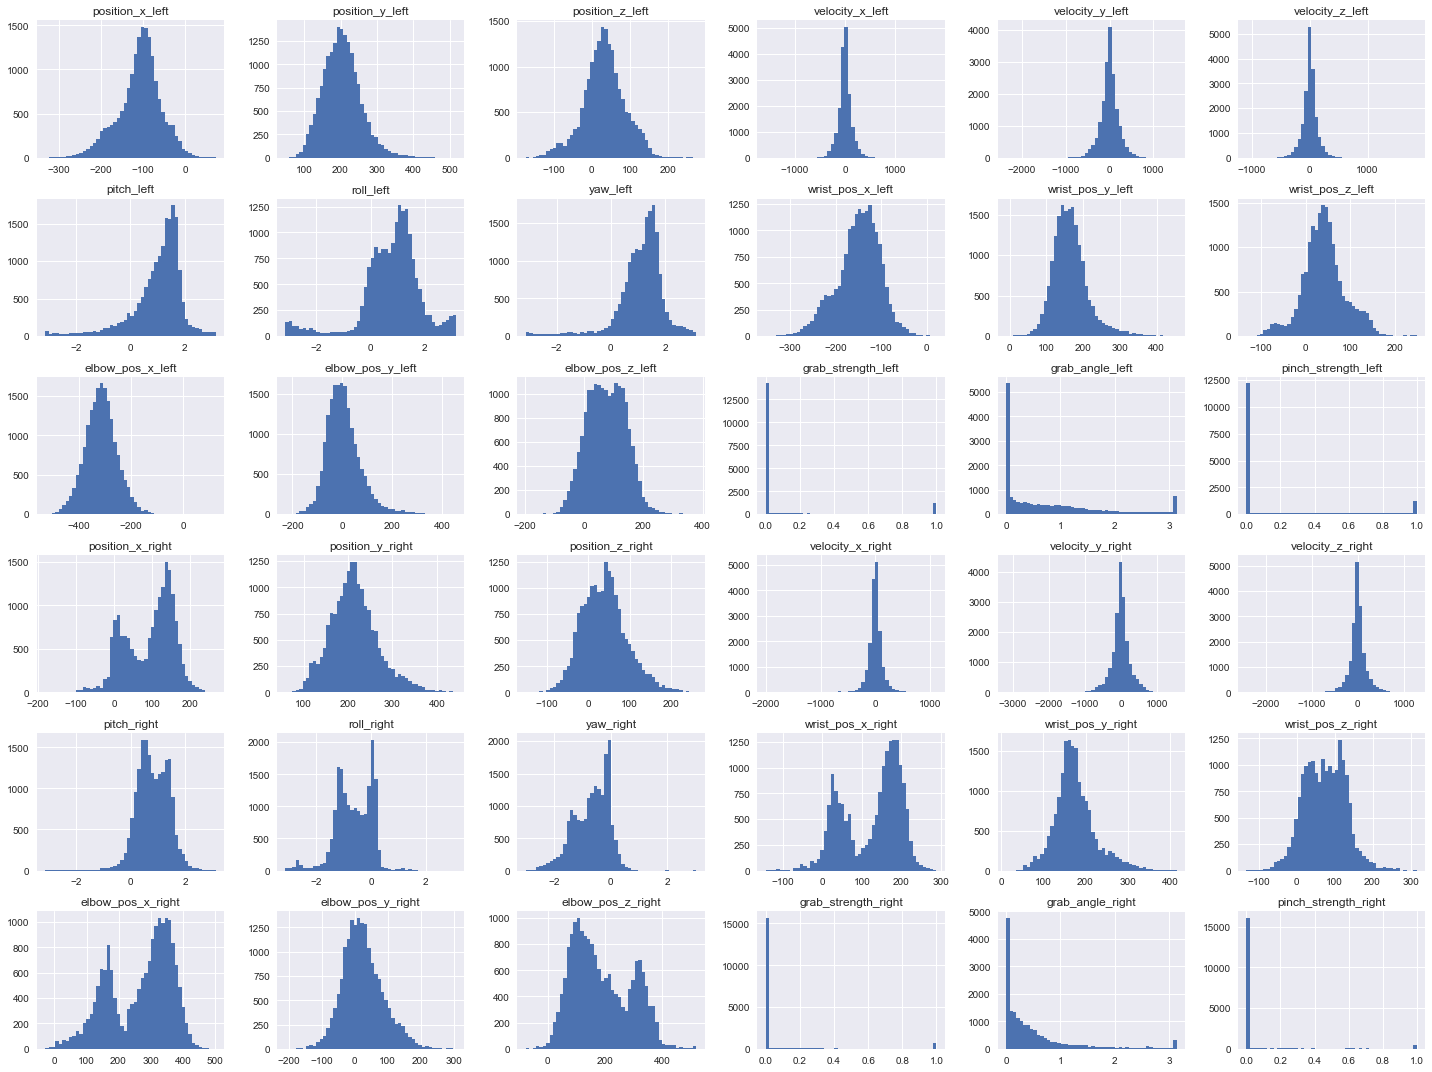

In [27]:
# histogram plot
hands.drop(["state", "time"], axis=1, inplace=False).hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

state_groups = hands.drop("time", axis=1, inplace=False).groupby("state")

state_groups.get_group(0).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15), color="red")
plt.suptitle("Alone", size=25)
plt.tight_layout()
plt.show()

state_groups.get_group(1).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15), color='orange')
plt.suptitle("Spontaneous", size=25)
plt.tight_layout()
plt.show()

state_groups.get_group(2).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15), color="green")
plt.suptitle("Sync", size=25)
plt.tight_layout()
plt.show()

> Initial observations from the histograms:
1. The attributes have different scales. Some values are between 0-1, while others are in the range of hundreds or
even thousands and contain negative values.
2. Most of the attributes have a relatively normal distribution. Some are a bit tail-heavy (extend farther to the
left or right).

> ### Looking for Correlations:
> Correlations measure the linear relationships between the features.
> A strong positive correlation is close to 1 and a strong negative correlation is close to -1.
> Looking for correlations with the 'state' column can emphasize which features are most significant.

In [28]:
corr_matrix = hands.corr()
corr_matrix["state"].sort_values(ascending=False)

state                   1.000000
elbow_pos_x_right       0.702425
wrist_pos_x_right       0.637521
position_x_right        0.589749
pitch_right             0.441167
roll_left               0.224163
pitch_left              0.164584
time                    0.157965
position_y_right        0.155290
position_z_left         0.139623
wrist_pos_z_left        0.126117
position_y_left         0.053597
wrist_pos_y_right       0.003142
velocity_x_right        0.000842
grab_strength_right     0.000139
velocity_y_right       -0.000551
velocity_x_left        -0.001046
velocity_z_left        -0.002451
velocity_y_left        -0.004117
velocity_z_right       -0.006231
position_z_right       -0.020253
yaw_left               -0.023572
elbow_pos_z_left       -0.031070
elbow_pos_x_left       -0.062050
pinch_strength_right   -0.076201
wrist_pos_y_left       -0.108661
grab_strength_left     -0.117155
pinch_strength_left    -0.150396
grab_angle_right       -0.156458
wrist_pos_x_left       -0.196563
grab_angle

> Observations:
* From looking at the values, clearly the right hand has a greater influence than the left.
An assumption can be made that using the same right-hand data for all the 'alone' state files had an influence
on the right-hand correlations.
* Velocity has a low correlation for both hands and all three planes.
* Pinch and grab strength

> ### Evaluating Feature Combinations

> #### Combining position and wrist pos columns (by plane and hand type):

In [95]:
pos_df = hands.filter(regex="wrist_pos|position")
pos_left = pos_df.filter(regex="left").columns.tolist()
pos_right = pos_df.filter(regex="right").columns.tolist()

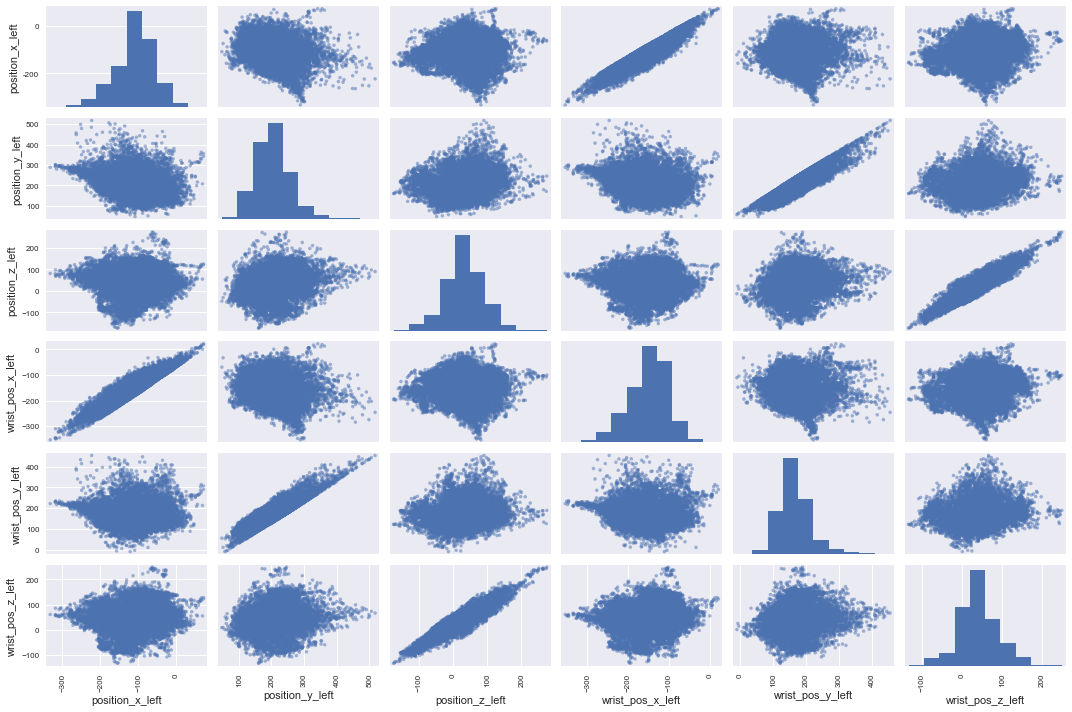

In [96]:
scatter_matrix(hands[pos_left], figsize=(15, 10))
plt.tight_layout()
plt.show()

In [97]:
hands.groupby("state")[pos_left].agg(["mean", "min", "max"]).T

state                           0           1           2
position_x_left  mean  -83.824764 -118.760171 -121.315705
                 min  -272.855500 -318.341600 -332.468400
                 max    73.042840  -18.702670   -8.088392
position_y_left  mean  204.239144  196.812382  211.202243
                 min    48.088670   57.297520   51.755280
                 max   467.230100  478.120900  517.504200
position_z_left  mean   18.421899   40.412795   37.259362
                 min  -174.118000 -101.868800 -117.853900
                 max   274.052500  211.484000  177.915000
wrist_pos_x_left mean -130.626124 -164.590324 -153.727863
                 min  -262.741500 -349.793600 -353.456800
                 max    21.534310  -53.257940  -33.314710
wrist_pos_y_left mean  173.082230  162.779453  160.059155
                 min    28.831890   -9.197065   10.660210
                 max   447.871900  437.679800  454.272000
wrist_pos_z_left mean   28.261837   50.846166   43.026145
                 min  -133.127500  -84.282010  -85.224620
                 max   248.930500  193.700600  188.073700

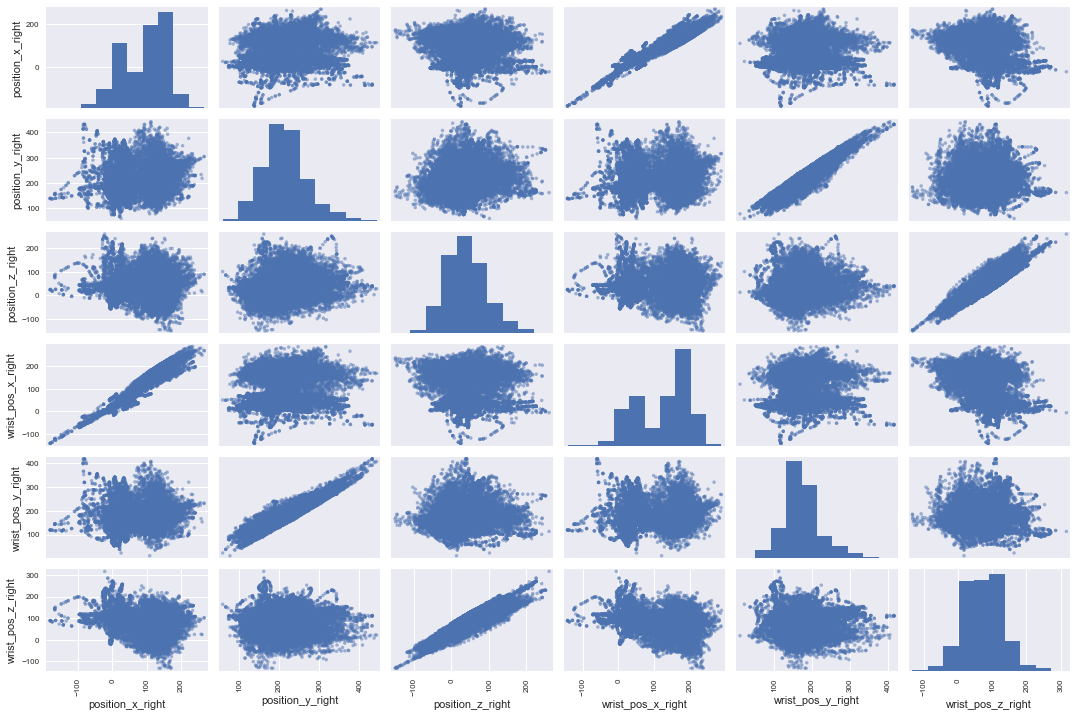

In [98]:
scatter_matrix(hands[pos_right], figsize=(15, 10))
plt.tight_layout()
plt.show()

In [99]:
hands.groupby("state")[pos_right].agg(["mean", "min", "max"]).T

state                            0           1           2
position_x_right  mean   21.690523  142.148493  115.985244
                  min  -180.878400   58.504370  -80.052650
                  max   241.939500  258.101500  267.737300
position_y_right  mean  202.440985  217.555267  223.097762
                  min    59.404940   77.570310   88.841620
                  max   431.855900  442.851200  436.593500
position_z_right  mean   43.184117   34.076223   40.462353
                  min   -56.885730 -150.438000 -118.935700
                  max   260.237800  242.370600  240.661700
wrist_pos_x_right mean   37.549913  185.013547  152.157857
                  min  -142.189800  109.104000  -51.175230
                  max   219.866800  288.231200  287.240700
wrist_pos_y_right mean  172.638151  181.154864  173.029527
                  min    23.062180   11.438540   35.064980
                  max   415.878300  405.442800  404.113000
wrist_pos_z_right mean  105.159592   59.687941   56.002295
                  min   -20.995500 -132.481900  -80.888120
                  max   316.406300  249.240200  259.740200

> Looking at the values that match each position according to hand type and plane, it looks like the
> values are roughly in the same range. This means that the attribute combinations can be tested
> without normalizing beforehand.
>
> I will try combining the position features by plane and hand type into one by calculating the mean, a total of
> 6 new features.

In [32]:
# compute the mean into a new column

hands["mean_pos_x_left"] = (hands["wrist_pos_x_left"] + hands["position_x_left"]) / 2
hands["mean_pos_y_left"] = (hands["wrist_pos_y_left"] + hands["position_y_left"]) / 2
hands["mean_pos_z_left"] = (hands["wrist_pos_z_left"] + hands["position_z_left"]) / 2

hands["mean_pos_x_right"] = (hands["wrist_pos_x_right"] + hands["position_x_right"]) / 2
hands["mean_pos_y_right"] = (hands["wrist_pos_y_right"] + hands["position_y_right"]) / 2
hands["mean_pos_z_right"] = (hands["wrist_pos_z_right"] + hands["position_z_right"]) / 2

In [33]:
pos_cols = hands.filter(regex="wrist_pos|position|mean_pos").columns.tolist()
pos_cols

['position_x_left',
 'position_y_left',
 'position_z_left',
 'wrist_pos_x_left',
 'wrist_pos_y_left',
 'wrist_pos_z_left',
 'position_x_right',
 'position_y_right',
 'position_z_right',
 'wrist_pos_x_right',
 'wrist_pos_y_right',
 'wrist_pos_z_right',
 'mean_pos_x_left',
 'mean_pos_y_left',
 'mean_pos_z_left',
 'mean_pos_x_right',
 'mean_pos_y_right',
 'mean_pos_z_right']

In [34]:
corr_matrix = hands.corr()
corr_matrix["state"][pos_cols].sort_values(ascending=False)

wrist_pos_x_right    0.637521
mean_pos_x_right     0.619503
position_x_right     0.589749
position_y_right     0.155290
position_z_left      0.139623
mean_pos_z_left      0.136534
wrist_pos_z_left     0.126117
mean_pos_y_right     0.084400
position_y_left      0.053597
wrist_pos_y_right    0.003142
position_z_right    -0.020253
mean_pos_y_left     -0.024941
wrist_pos_y_left    -0.108661
wrist_pos_x_left    -0.196563
mean_pos_z_right    -0.199760
mean_pos_x_left     -0.253879
position_x_left     -0.296208
wrist_pos_z_right   -0.364870
Name: state, dtype: float64

> Observations:
* Overall, it seems that the new columns represent the correlation well.
It will be useful to implement a transformer for this to easily evaluate the results during model training.
* This feature combination could possibly be used instead of the original features, which would reduce
dimensionality a bit.

> #### Combining grab strength and angle columns:

In [35]:
# get list of column names
grab_cols = hands.filter(regex="grab").columns.tolist()
grab_cols

['grab_strength_left',
 'grab_angle_left',
 'grab_strength_right',
 'grab_angle_right']

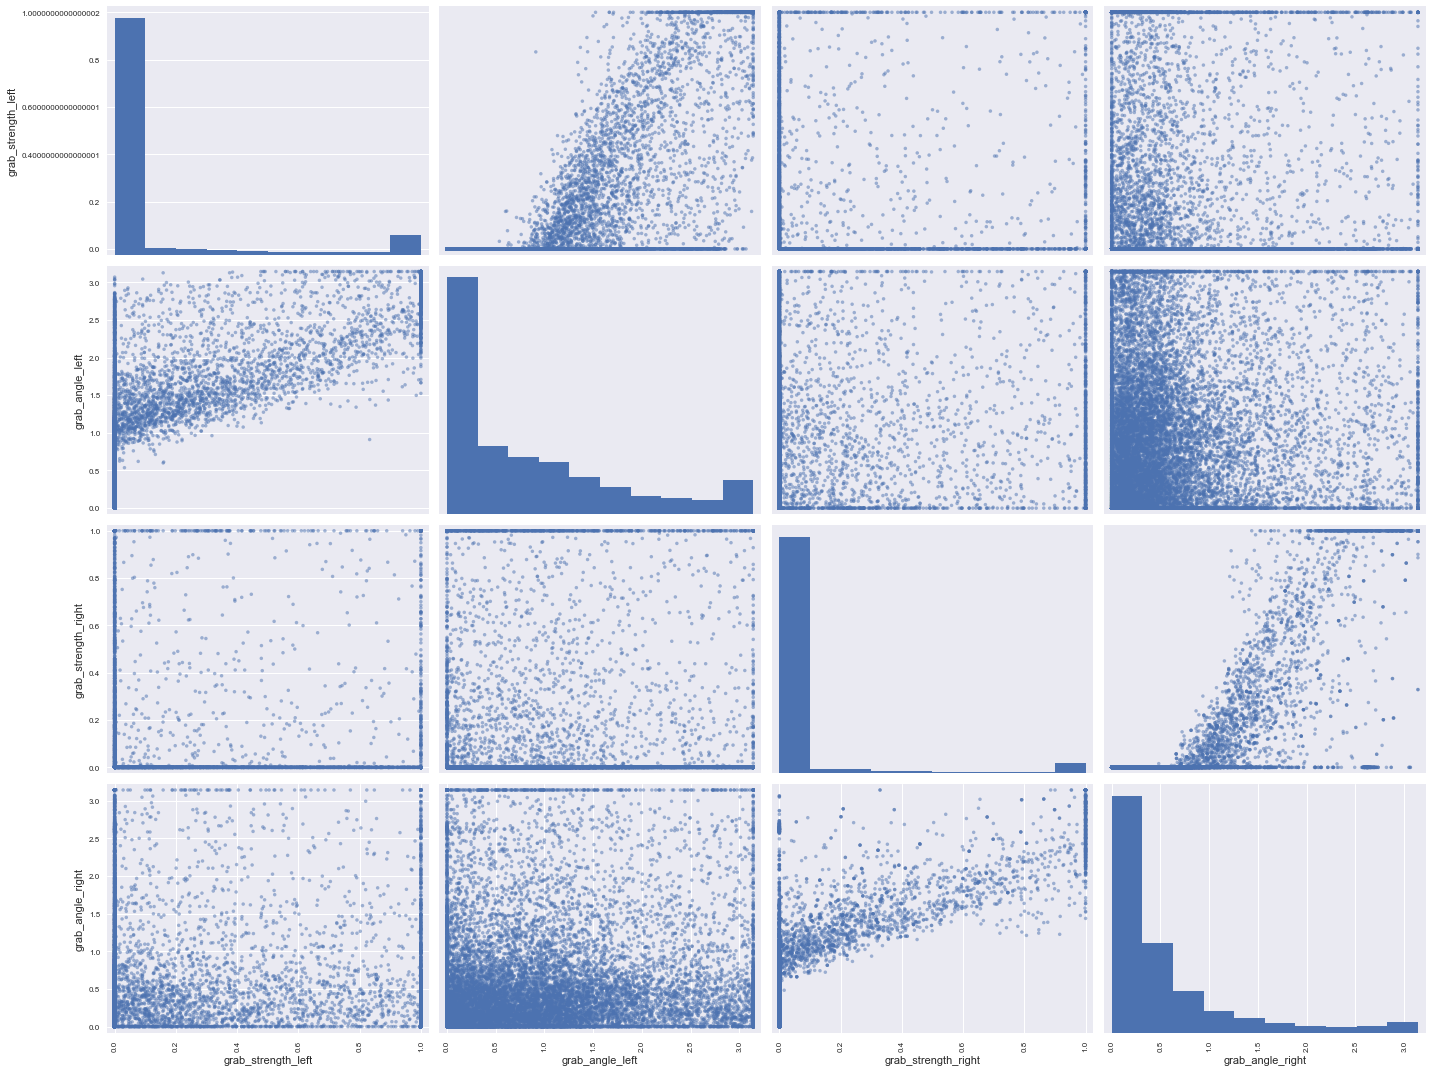

In [36]:
# plot correlation matrix
scatter_matrix(hands[grab_cols], figsize=(20, 15))
plt.tight_layout()
plt.show()

> There is a pretty strong correlation between the grab angle and strength for each hand type.

In [37]:
# aggregate columns by alignment state
hands.groupby("state")[grab_cols].agg(["mean", "min", "max"]).T

state                            0         1         2
grab_strength_left  mean  0.154843  0.127289  0.073085
                    min   0.000000  0.000000  0.000000
                    max   1.000000  1.000000  1.000000
grab_angle_left     mean  1.015745  0.965769  0.489213
                    min   0.000000  0.000000  0.000000
                    max   3.141593  3.141593  3.141593
grab_strength_right mean  0.070514  0.063856  0.070582
                    min   0.000000  0.000000  0.000000
                    max   1.000000  1.000000  1.000000
grab_angle_right    mean  0.646121  0.542769  0.379275
                    min   0.000000  0.000000  0.000000
                    max   3.141593  3.141593  3.141593

> It is clear that strength is a value between 0 and 1 and the angle is between 0 and pi.
> In order to combine these features, I will first normalize the angle range to 0 and 1,
> then compute the mean, adding 2 new columns.

In [38]:
# normalize angle values to the same scale as grab strength
# angle = [0, pi], grab strength = [0, 1]
grab_angle_left_norm = hands["grab_angle_left"] / hands["grab_angle_left"].max()
grab_angle_right_norm = hands["grab_angle_right"] / hands["grab_angle_right"].max()

# compute the mean into a new column
hands["grab_left"] = (hands["grab_strength_left"] + grab_angle_left_norm) / 2
hands["grab_right"] = (hands["grab_strength_right"] + grab_angle_right_norm) / 2

In [39]:
# get list with added columns
grab_cols = hands.filter(regex="grab").columns.tolist()
grab_cols

['grab_strength_left',
 'grab_angle_left',
 'grab_strength_right',
 'grab_angle_right',
 'grab_left',
 'grab_right']

In [40]:
# show correlation with added columns
corr_matrix = hands.corr()
corr_matrix["state"][grab_cols].sort_values(ascending=False)

grab_strength_right    0.000139
grab_right            -0.082175
grab_strength_left    -0.117155
grab_angle_right      -0.156458
grab_left             -0.186504
grab_angle_left       -0.233143
Name: state, dtype: float64

> Observations:
* While grab left seems to provide a seemingly high correlation, grab right very little correlation
compared to grab angle right, which is a lot more correlated.
* Grab strength right has a positive correlation, unlike grab angle right and the newly combined feature, grab right.
* Overall, it seems that the new features mostly cause information loss and don't provide much more information
(especially the grab right feature, which is hardly correlated).
Therefore, I will not use it for further analysis.

In [41]:
# drop the combined feature columns
hands.drop(["grab_left", "grab_right"], axis=1, inplace=True)

> Taking another look at the correlations:

In [42]:
corr_matrix = hands.corr()
corr_matrix["state"].sort_values(ascending=False)

state                   1.000000
elbow_pos_x_right       0.702425
wrist_pos_x_right       0.637521
mean_pos_x_right        0.619503
position_x_right        0.589749
pitch_right             0.441167
roll_left               0.224163
pitch_left              0.164584
time                    0.157965
position_y_right        0.155290
position_z_left         0.139623
mean_pos_z_left         0.136534
wrist_pos_z_left        0.126117
mean_pos_y_right        0.084400
position_y_left         0.053597
wrist_pos_y_right       0.003142
velocity_x_right        0.000842
grab_strength_right     0.000139
velocity_y_right       -0.000551
velocity_x_left        -0.001046
velocity_z_left        -0.002451
velocity_y_left        -0.004117
velocity_z_right       -0.006231
position_z_right       -0.020253
yaw_left               -0.023572
mean_pos_y_left        -0.024941
elbow_pos_z_left       -0.031070
elbow_pos_x_left       -0.062050
pinch_strength_right   -0.076201
wrist_pos_y_left       -0.108661
grab_stren

# 3. Data Cleaning

In [43]:
# clean copy of the training set
df = train_set.copy()

In [44]:
# BaseEstimator for enabling hyperparameters
# TransformerMixin adds fit_transform method
class CombinedFeaturesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, combine_position_wrist=False):
        self.combine_position_wrist = combine_position_wrist

    def fit(self, X, y=None):
        return self # no fitting needed

    def transform(self, X):
        mean_pos_x_left = (X["wrist_pos_x_left"] + X["position_x_left"]) / 2
        mean_pos_y_left = (X["wrist_pos_y_left"] + X["position_y_left"]) / 2
        mean_pos_z_left = (X["wrist_pos_z_left"] + X["position_z_left"]) / 2
        mean_pos_x_right = (X["wrist_pos_x_right"] + X["position_x_right"]) / 2
        mean_pos_y_right = (X["wrist_pos_y_right"] + X["position_y_right"]) / 2
        mean_pos_z_right = (X["wrist_pos_z_right"] + X["position_z_right"]) / 2
        if self.combine_position_wrist:
            return pd.concat([X, mean_pos_x_left.rename("mean_pos_x_left"), mean_pos_x_right.rename("mean_pos_x_right"),
                       mean_pos_y_left.rename("mean_pos_y_left"), mean_pos_y_right.rename("mean_pos_y_right"),
                       mean_pos_z_left.rename("mean_pos_z_left"), mean_pos_z_right.rename("mean_pos_z_right")], axis=1)
        return X

In [45]:
# custom transformer drops features from dataframe
class DropColumns(TransformerMixin, BaseEstimator):

    def __init__(self, col_names=None):
        self.col_names = col_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.col_names is not None:
            return X.drop(self.col_names, axis=1)
        return X

In [46]:
hands = train_set.copy()
mean_pos_x_left = (hands["wrist_pos_x_left"] + hands["position_x_left"]) / 2
mean_pos_y_left = (hands["wrist_pos_y_left"] + hands["position_y_left"]) / 2
mean_pos_z_left = (hands["wrist_pos_z_left"] + hands["position_z_left"]) / 2
mean_pos_x_right = (hands["wrist_pos_x_right"] + hands["position_x_right"]) / 2
mean_pos_y_right = (hands["wrist_pos_y_right"] + hands["position_y_right"]) / 2
mean_pos_z_right = (hands["wrist_pos_z_right"] + hands["position_z_right"]) / 2

new = pd.concat([hands, mean_pos_x_left.rename("mean_pos_x_left"), mean_pos_x_right.rename("mean_pos_x_right"),
                 mean_pos_y_left.rename("mean_pos_y_left"), mean_pos_y_right.rename("mean_pos_y_right"),
                 mean_pos_z_left.rename("mean_pos_z_left"), mean_pos_z_right.rename("mean_pos_z_right")], axis=1)

new.isna().sum()

state                   0
time                    0
position_x_left         0
position_y_left         0
position_z_left         0
velocity_x_left         0
velocity_y_left         0
velocity_z_left         0
pitch_left              0
roll_left               0
yaw_left                0
wrist_pos_x_left        0
wrist_pos_y_left        0
wrist_pos_z_left        0
elbow_pos_x_left        0
elbow_pos_y_left        0
elbow_pos_z_left        0
grab_strength_left      0
grab_angle_left         0
pinch_strength_left     0
position_x_right        0
position_y_right        0
position_z_right        0
velocity_x_right        0
velocity_y_right        0
velocity_z_right        0
pitch_right             0
roll_right              0
yaw_right               0
wrist_pos_x_right       0
wrist_pos_y_right       0
wrist_pos_z_right       0
elbow_pos_x_right       0
elbow_pos_y_right       0
elbow_pos_z_right       0
grab_strength_right     0
grab_angle_right        0
pinch_strength_right    0
mean_pos_x_l

> ### Feature Scaling
>
> Chosen feature scale:
>
> Standardizing centers the data so that it has a zero mean and a standard deviation of 1, under the assumption
> that the data is normally distributed.
* The distribution is relatively normal.
* PCA assumes the data has zero mean and could be a useful dimensionality reduction technique,
since the values can be considered as continuous.
>
> Therefore, standard scaling is the ideal option.

In [47]:
drop_cols = ["time"]

full_pipeline = Pipeline([
    ("feat_adder", CombinedFeaturesAdder()),
    ("drop", DropColumns(drop_cols)),
    ("std_scl", StandardScaler())
])

# 4. Training and Evaluating Models

> Since there is a slight imbalance between the classes, accuracy can be a bit deceiving.
> Evaluating by a metric that represents the data better is important.
>
> Chosen evaluation metric:
>
> The F1 Score is calculated by using precision (the accuracy of the positive predictions) and
> recall (the ratio of positive instances correctly classified) accuracy.
> This metric gives a higher value towards false positives rather than false negatives.

In [48]:
# function prints scores
def display_evaluation(actual, pred, print_conf_mat = False, print_report=False):
    # weighted average for multiclass, considers the proportion of each class
    print("F1 Score:", round(metrics.f1_score(actual, pred, average="weighted"), 5))
    print("Accuracy:", round(metrics.accuracy_score(actual, pred), 5), "\n")
    if print_conf_mat:
        print("Confusion Matrix:\n", metrics.confusion_matrix(actual, pred), "\n")
    if print_report:
        print("Classification Report:\n", metrics.classification_report(actual, pred))

def return_scores(actual, pred):
    F1 = round(metrics.f1_score(actual, pred, average="weighted"), 5)
    accuracy = round(metrics.accuracy_score(actual, pred), 5)
    return F1, accuracy

> Time series data is sensitive and shuffling the data could be problematic. For instance, if the model
> was trained on the hand motion at time x-1 and x+1, it should easily be able to predict the state of the motion
> at time x. Therefore, regular model evaluations can not be used here.
>
> In this case, there are two main approaches that can be used to evaluate the models during training:
1. Take the last 5 seconds from each file for the validation set and remove an additional 2 seconds to
create a time gap (otherwise, the models should easily be able to predict the state of the motion that occurred
a second later).
2. Train the model on 8 participants and use the last person as a validation set.

In [49]:
# function splits training data into a training set and validations set
# 2 second difference between train and validation

def split_train_val(data):
    train = []
    val = []
    for i in range(len(data)):
        df = data[i]
        train.append(df.drop(df[df["time"] > df["time"].max() - 7].index)) # drop last 7 seconds
        val.append(df.drop(df[df["time"] < df["time"].max() - 5].index)) # append last 5 seconds
    trainX = pd.concat(train, axis=0, ignore_index=True)
    valX = pd.concat(val, axis=0, ignore_index=True)
    return trainX, valX

In [50]:
# split training data
train, val = split_train_val(load_data(train_path, as_pandas=False))
# separate labels from data
X_train = train.drop("state", axis=1)
y_train = train.state.copy()
X_val = val.drop("state", axis=1)
y_val = val.state.copy()

In [51]:
# transform data
X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared = full_pipeline.transform(X_val)

In [52]:
log_reg_scores = []
knn_scores = []
tree_scores = []
rf_scores = []

### 1. Logistic Regression

In [53]:
log_reg = LogisticRegression(multi_class='multinomial', random_state=42, n_jobs=-1)
log_reg.fit(X_train_prepared, y_train)
log_reg_pred_1 = log_reg.predict(X_val_prepared)
display_evaluation(y_val, log_reg_pred_1)
log_reg_scores.append(return_scores(y_val, log_reg_pred_1))

F1 Score: 0.89315
Accuracy: 0.89315 



### 2. KNN

In [54]:
# uniform weights
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train_prepared, y_train)
knn_pred_2 = knn.predict(X_val_prepared)
display_evaluation(y_val, knn_pred_2)
knn_scores.append(return_scores(y_val, knn_pred_2))

F1 Score: 0.92254
Accuracy: 0.92262 



### 3. Decision Tree Classifier

In [55]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_prepared, y_train)
tree_pred_3 = tree_clf.predict(X_val_prepared)
display_evaluation(y_val, tree_pred_3)
tree_scores.append(return_scores(y_val, tree_pred_3))

F1 Score: 0.89073
Accuracy: 0.89094 



### 4. Random Forest Classifier

In [56]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train_prepared, y_train)
rf_pred_4 = rf_clf.predict(X_val_prepared)
display_evaluation(y_val, rf_pred_4)
rf_scores.append(return_scores(y_val, rf_pred_4))

F1 Score: 0.92999
Accuracy: 0.92999 



> When looking at the corr matrix, all velocity attributes had very little correlation to the 'state' feature.
> Let's train the same models this time without the velocity features and compare the results.

In [57]:
drop_cols = train.filter(regex="time|velocity").columns.tolist() # get list with column names
full_pipeline["drop"].__setattr__("col_names", drop_cols) # set transformer hyperparameter with new list
full_pipeline.steps[1] # check that the hyperparameter changed

('drop',
 DropColumns(col_names=['time', 'velocity_x_left', 'velocity_y_left',
                        'velocity_z_left', 'velocity_x_right',
                        'velocity_y_right', 'velocity_z_right']))

In [58]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared = full_pipeline.transform(X_val)

### 5. Logistic Regression

In [59]:
log_reg.fit(X_train_prepared, y_train)
log_reg_pred_5 = log_reg.predict(X_val_prepared)
display_evaluation(y_val, log_reg_pred_5)
log_reg_scores.append(return_scores(y_val, log_reg_pred_5))

F1 Score: 0.89088
Accuracy: 0.89094 



### 6. KNN

In [60]:
knn.fit(X_train_prepared, y_train)
knn_pred_6 = knn.predict(X_val_prepared)
display_evaluation(y_val, knn_pred_6)
knn_scores.append(return_scores(y_val, knn_pred_6))

F1 Score: 0.92408
Accuracy: 0.9241 



### 7. Decision Tree Classifier

In [61]:
tree_clf.fit(X_train_prepared, y_train)
tree_pred_7 = tree_clf.predict(X_val_prepared)
display_evaluation(y_val, tree_pred_7)
tree_scores.append(return_scores(y_val, tree_pred_7))

F1 Score: 0.87532
Accuracy: 0.87546 



### 8. Random Forest Classifier

In [62]:
rf_clf.fit(X_train_prepared, y_train)
rf_pred_8 = rf_clf.predict(X_val_prepared)
display_evaluation(y_val, rf_pred_8)
rf_scores.append(return_scores(y_val, rf_pred_8))

F1 Score: 0.92557
Accuracy: 0.92557 



> Observations:
* The F1 score and accuracy were both higher for all 4 models without the velocity feature!

> Next, I'll train the models with a couple new features, the position and wrist position mean for each
> plane and hand type.

In [63]:
full_pipeline["feat_adder"].__setattr__("combine_position_wrist", True)
full_pipeline.steps[0] # check that the hyperparameter changed

('feat_adder', CombinedFeaturesAdder(combine_position_wrist=True))

In [64]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared = full_pipeline.transform(X_val)

### 9. Logistic Regression

In [65]:
log_reg.fit(X_train_prepared, y_train)
log_reg_pred_9 = log_reg.predict(X_val_prepared)
display_evaluation(y_val, log_reg_pred_9)
log_reg_scores.append(return_scores(y_val, log_reg_pred_9))

F1 Score: 0.89088
Accuracy: 0.89094 



### 10. KNN

In [66]:
knn.fit(X_train_prepared, y_train)
knn_pred_10 = knn.predict(X_val_prepared)
display_evaluation(y_val, knn_pred_10)
knn_scores.append(return_scores(y_val, knn_pred_10))

F1 Score: 0.92336
Accuracy: 0.92336 



### 11. Decision Tree Classifier

In [67]:
tree_clf.fit(X_train_prepared, y_train)
tree_pred_11 = tree_clf.predict(X_val_prepared)
display_evaluation(y_val, tree_pred_11)
tree_scores.append(return_scores(y_val, tree_pred_11))

F1 Score: 0.89161
Accuracy: 0.89167 



### 12. Random Forest Classifier

In [68]:
rf_clf.fit(X_train_prepared, y_train)
rf_pred_12 = rf_clf.predict(X_val_prepared)
display_evaluation(y_val, rf_pred_12)
rf_scores.append(return_scores(y_val, rf_pred_12))

F1 Score: 0.91894
Accuracy: 0.91894 



> Observations:
* Logistic Regression: overall had the same scores.
* KNN: F1 score increased from 0.89 to 0.92, accuracy was the same.
* Decision Tree: F1 score increased from 0.85 to 0.87, accuracy increased by about 0.5.
* Random Forest: F1 score decreased from 0.93 to 0.92, accuracy decreased from 0.94 to 0.92.

> Let's test with the new features, this time dropping both position and wrist position.
> Note: This will reduce the amount of features in the data even prior to adding the new ones.

In [69]:
log_reg_df = pd.DataFrame(log_reg_scores, columns=["log_reg_f1", "log_reg_accuracy"])
knn_df = pd.DataFrame(knn_scores, columns=["knn_f1", "knn_accuracy"])
tree_df = pd.DataFrame(tree_scores, columns=["tree_f1", "tree_accuracy"])
rf_df = pd.DataFrame(rf_scores, columns=["rf_f1", "rf_accuracy"])
res = pd.concat([log_reg_df, knn_df, tree_df, rf_df], axis=1)
res

,log_reg_f1,log_reg_accuracy,knn_f1,knn_accuracy,tree_f1,tree_accuracy,rf_f1,rf_accuracy
0,0.89315,0.89315,0.92254,0.92262,0.89073,0.89094,0.92999,0.92999
1,0.89088,0.89094,0.92408,0.92410,0.87532,0.87546,0.92557,0.92557
2,0.89088,0.89094,0.92336,0.92336,0.89161,0.89167,0.91894,0.91894


rf_clf.feature_importances_

importance_df = pd.DataFrame(list(zip(list(train.columns),rf_clf.feature_importances_, train.corr()["state"])),
                             columns = ['feature_name', 'importance','corr'])

print(importance_df.sort_values(by=['importance'],ascending=False))

> ### Grid Search Function:
> Sklearn uses cross-validation for hyperparameter tuning (GridSearchCV, RandomizedSearchCV, etc.)
> Time series data is sensitive to shuffling, therefore the following function provides
> a way to evaluate different estimator parameters using the validation set:

In [70]:
def grid_search(estimator, param_grid, Xtrain, ytrain, Xval, yval):
    scores = []
    model = clone(estimator)
    # ParameterGrid iterates value combinations for an estimator parameter search
    for params in ParameterGrid(param_grid):
        model.set_params(**params)
        model.fit(Xtrain, ytrain)
        pred = model.predict(Xval)
        f1_score = round(metrics.f1_score(yval, pred, average="weighted"), 5)
        accuracy_score = round(metrics.accuracy_score(yval, pred), 5)
        scores.append(("F1 score: {}".format(f1_score), "Accuracy: {}".format(accuracy_score), params))
    return scores

> ### PCA

In [71]:
pca = PCA()
pca.fit(X_train_prepared)
# cumulative sum (increasing by sequential addition) of components
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

16

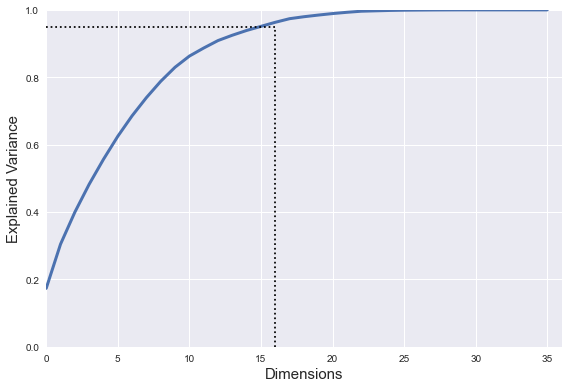

In [72]:
plt.axis([0, 36, 0, 1])  # axis limits
plt.plot(cumsum, linewidth=3)
plt.xlabel("Dimensions", size=15)
plt.ylabel("Explained Variance", size=15)
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.tight_layout()
plt.show()

### 13. Logistic Regression

> Before PCA:

In [73]:
display_evaluation(y_val, log_reg_pred_9)

F1 Score: 0.89088
Accuracy: 0.89094 



> After PCA:

In [74]:
pca_log_reg = Pipeline([
    ("pca", PCA()),
    ("log_reg", LogisticRegression(random_state=42, max_iter=400, n_jobs=-1))
])

param_grid = [{
    "pca__n_components": [0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
}]

grid_search(pca_log_reg, param_grid, X_train_prepared, y_train, X_val_prepared, y_val)

[('F1 score: 0.8487', 'Accuracy: 0.84967', {'pca__n_components': 0.89}),
 ('F1 score: 0.8487', 'Accuracy: 0.84967', {'pca__n_components': 0.9}),
 ('F1 score: 0.88511', 'Accuracy: 0.88504', {'pca__n_components': 0.91}),
 ('F1 score: 0.88511', 'Accuracy: 0.88504', {'pca__n_components': 0.92}),
 ('F1 score: 0.87992', 'Accuracy: 0.87988', {'pca__n_components': 0.93}),
 ('F1 score: 0.8755', 'Accuracy: 0.87546', {'pca__n_components': 0.94}),
 ('F1 score: 0.8755', 'Accuracy: 0.87546', {'pca__n_components': 0.95}),
 ('F1 score: 0.87696', 'Accuracy: 0.87693', {'pca__n_components': 0.96}),
 ('F1 score: 0.87401', 'Accuracy: 0.87399', {'pca__n_components': 0.97}),
 ('F1 score: 0.87991', 'Accuracy: 0.87988', {'pca__n_components': 0.98}),
 ('F1 score: 0.87174', 'Accuracy: 0.87178', {'pca__n_components': 0.99})]

### 14. Random Forest

> Random Forest before PCA:

In [75]:
display_evaluation(y_val, rf_pred_12)

F1 Score: 0.91894
Accuracy: 0.91894 



> Random Forest after PCA:

In [76]:
pca_rf_clf = Pipeline([
    ("pca", PCA()),
    ("rf_clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

grid_search(pca_rf_clf, param_grid, X_train_prepared, y_train, X_val_prepared, y_val)

[('F1 score: 0.91212', 'Accuracy: 0.91231', {'pca__n_components': 0.89}),
 ('F1 score: 0.91212', 'Accuracy: 0.91231', {'pca__n_components': 0.9}),
 ('F1 score: 0.941', 'Accuracy: 0.94105', {'pca__n_components': 0.91}),
 ('F1 score: 0.941', 'Accuracy: 0.94105', {'pca__n_components': 0.92}),
 ('F1 score: 0.93061', 'Accuracy: 0.93073', {'pca__n_components': 0.93}),
 ('F1 score: 0.93951', 'Accuracy: 0.93957', {'pca__n_components': 0.94}),
 ('F1 score: 0.93951', 'Accuracy: 0.93957', {'pca__n_components': 0.95}),
 ('F1 score: 0.93879', 'Accuracy: 0.93884', {'pca__n_components': 0.96}),
 ('F1 score: 0.93876', 'Accuracy: 0.93884', {'pca__n_components': 0.97}),
 ('F1 score: 0.94094', 'Accuracy: 0.94105', {'pca__n_components': 0.98}),
 ('F1 score: 0.9351', 'Accuracy: 0.93515', {'pca__n_components': 0.99})]

In [77]:
d = np.argmax(cumsum >= 0.91) + 1
d

14

> Conclusion:
* We can achieve nearly the same score with PCA, reducing features from 36 to 14.
* The F1 and accuracy scores drop below 0.91 explained variance.

In [78]:
# add PCA to pipeline
full_pipeline.steps.append(('pca', PCA(n_components=0.91)))
full_pipeline

Pipeline(steps=[('feat_adder',
                 CombinedFeaturesAdder(combine_position_wrist=True)),
                ('drop',
                 DropColumns(col_names=['time', 'velocity_x_left',
                                        'velocity_y_left', 'velocity_z_left',
                                        'velocity_x_right', 'velocity_y_right',
                                        'velocity_z_right'])),
                ('std_scl', StandardScaler()),
                ('pca', PCA(n_components=0.91))])

In [79]:
X_train_reduced = full_pipeline.fit_transform(X_train)
X_val_reduced = full_pipeline.transform(X_val)

### 15. KNN:

In [80]:
knn.fit(X_train_reduced, y_train)
knn_pred_15 = knn.predict(X_val_reduced)
display_evaluation(y_val, knn_pred_15)

F1 Score: 0.90774
Accuracy: 0.90789 



### 16. Decision Tree:

In [81]:
tree_clf.fit(X_train_reduced, y_train)
tree_pred_16 = tree_clf.predict(X_val_reduced)
display_evaluation(y_val, tree_pred_16)

F1 Score: 0.86498
Accuracy: 0.86514 



### 17. AdaBoost

In [82]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), random_state=42)
ada_clf.fit(X_train_reduced, y_train)
ada_pred_17 = ada_clf.predict(X_val_reduced)
display_evaluation(y_val, ada_pred_17)

F1 Score: 0.86721
Accuracy: 0.86735 



### 18. XGBoost

In [83]:
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='merror', objective='multi:softmax',
                        num_class=3, use_label_encoder=False)
xgb_clf.fit(X_train_reduced, y_train)
xgb_pred_18 = xgb_clf.predict(X_val_reduced)
display_evaluation(y_val, xgb_pred_18)

F1 Score: 0.94755
Accuracy: 0.94768 



> #### Looking Back:
* The best models (from lowest to highest scores): Logistic Regression, KNN, Random Forest and XGBoost.
* Decision Tree and AdaBoost models had the lowest performance, with 86% F1 and accuracy scores.
>
> The pre-processing steps and baseline models have been analyzed.
> The next step is to find the finest hyperparameters for the best models.

### Fine-Tune Logistic Regression

In [84]:
log_reg.fit(X_train_reduced, y_train)
log_reg_pred = log_reg.predict(X_val_reduced)
display_evaluation(y_val, log_reg_pred)

F1 Score: 0.88511
Accuracy: 0.88504 



> * When the Logistic Regression parameter 'multi_class' is set to 'multinomial', it is using Softmax Regression
which is optimized for multi-class inputs. Simply put, it estimates the probability that an instance belongs
to each class and predicts the highest one. The sum of all probabilities is equal to 1.
* Another approach: One-vs-One and One-vs-Rest wrapper methods.
>
> I'll search for the best hyperparameters, then try applying the best estimator with the wrapper methods.

> Tuning solver and penalty:

In [85]:
# lbfgs - default sklearn solver
# both lbfgs and newton-cg work well with smaller datasets

# both sag and saga solvers work well with large datasets
# they are a variation of gradient descent
# convergence is faster when the data is scaled
# sag = stochastic average gradient, saga = variant of sag solver

param_grid = [
    {"solver": ["lbfgs", "newton-cg", "sag", "saga"]}
]

grid_search(log_reg, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

[('F1 score: 0.88511', 'Accuracy: 0.88504', {'solver': 'lbfgs'}),
 ('F1 score: 0.88511', 'Accuracy: 0.88504', {'solver': 'newton-cg'}),
 ('F1 score: 0.88511', 'Accuracy: 0.88504', {'solver': 'sag'}),
 ('F1 score: 0.88511', 'Accuracy: 0.88504', {'solver': 'saga'})]

> Tuning the regularization strength:

In [86]:
param_grid = [{
    "solver": ["lbfgs"],
    "C": [0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 1.]  # C controls regularization,
    # light penalty if close to 1.0, strong penalty if close to 0.0
}]

grid_search(log_reg, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

[('F1 score: 0.87639', 'Accuracy: 0.87693', {'C': 0.001, 'solver': 'lbfgs'}),
 ('F1 score: 0.8821', 'Accuracy: 0.88209', {'C': 0.01, 'solver': 'lbfgs'}),
 ('F1 score: 0.88438', 'Accuracy: 0.8843', {'C': 0.1, 'solver': 'lbfgs'}),
 ('F1 score: 0.88511', 'Accuracy: 0.88504', {'C': 0.2, 'solver': 'lbfgs'}),
 ('F1 score: 0.88511', 'Accuracy: 0.88504', {'C': 0.5, 'solver': 'lbfgs'}),
 ('F1 score: 0.88511', 'Accuracy: 0.88504', {'C': 0.8, 'solver': 'lbfgs'}),
 ('F1 score: 0.88511', 'Accuracy: 0.88504', {'C': 1.0, 'solver': 'lbfgs'})]

> **Final Logistic Regression model:** Lbfgs solver, l2 norm and 0.2 penalty.

In [87]:
log_reg_final = LogisticRegression(multi_class='multinomial', C=0.2, random_state=42, n_jobs=-1)
log_reg_final.fit(X_train_reduced, y_train)
log_reg_final_pred = log_reg_final.predict(X_val_reduced)
display_evaluation(y_val, log_reg_final_pred)

F1 Score: 0.88511
Accuracy: 0.88504 



### Fine-Tune KNN

In [88]:
display_evaluation(y_val, knn_pred_15)

F1 Score: 0.90774
Accuracy: 0.90789 



> Tuning weights and penalty:

In [89]:
param_grid = [{
    "weights": ['uniform', 'distance'],
    "p": [1, 2]
}]

grid_search(knn, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

[('F1 score: 0.91496', 'Accuracy: 0.91525', {'p': 1, 'weights': 'uniform'}),
 ('F1 score: 0.91352', 'Accuracy: 0.91378', {'p': 1, 'weights': 'distance'}),
 ('F1 score: 0.90774', 'Accuracy: 0.90789', {'p': 2, 'weights': 'uniform'}),
 ('F1 score: 0.90704', 'Accuracy: 0.90715', {'p': 2, 'weights': 'distance'})]

> Tuning number of neighbors:
>> Note: There is an odd number of classes. It is better to choose an even number of neighbors to
>> prevent ties.

In [90]:
param_grid = [{
    "p": [1],
    "n_neighbors": [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22 ,24, 26, 28, 30]
}]

grid_search(knn, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

KeyboardInterrupt: 

> **Final KNN model:** Uniform weights, l1 norm and 8 neighbors.
>> Note: The final KNN model has a higher accuracy than the final Logistic Regression model!

In [ ]:
knn_final = KNeighborsClassifier(p=1, n_neighbors=8, n_jobs=-1)
knn_final.fit(X_train_reduced, y_train)
knn_final_pred = knn_final.predict(X_val_reduced)
display_evaluation(y_val, knn_final_pred)

### Fine-Tune Random Forest

In [ ]:
rf_clf.fit(X_train_reduced, y_train)
rf_clf_pred = rf_clf.predict(X_val_reduced)
display_evaluation(y_val, rf_clf_pred)

> Tuning maximum number features per tree:
>> Note: If this hyperparameter is set to 'None', it evaluates all features. When dealing with high
> dimensional data (such as image classification) it can be convenient to select a smaller amount
> of features.

In [ ]:
param_grid = [{
    "max_features": ['sqrt', "log2", 0.1, 0.2, 0.5, 0.8, None]  # max features that are evaluated before splitting a node
}]

grid_search(rf_clf, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

> Tuning number of trees with Bagging and Pasting:
>> Note: More estimators tend to improve accuracy at the expense of increasing the computation time.
> Additionally, from a certain amount of trees the model performance does not change much.

In [ ]:
param_grid = [{
    "n_estimators": [30, 50, 100], # number of trees in the forest
    "bootstrap": [True, False], # sampling with or without replacement
    # True (sklearn default) = bagging, False = pasting
    "criterion": ["gini", "entropy"] # function to measure quality of split
}]

grid_search(rf_clf, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

> **Final Random Forest model:** 100 estimators, bagging method (sampling with replacement), and considers
> sqrt amount of features when splitting a node.

In [ ]:
rf_clf_final = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf_final.fit(X_train_reduced, y_train)
rf_clf_final_pred = rf_clf_final.predict(X_val_reduced)
display_evaluation(y_val, rf_clf_final_pred)

### Fine-Tune XGBoost

In [ ]:
display_evaluation(y_val, xgb_pred_18)

> Tuning the number of estimators:

In [ ]:
eval_set = [(X_train_reduced, y_train), (X_val_reduced, y_val)]
xgb_clf2 = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='merror', objective='multi:softmax',
                        num_class=3, use_label_encoder=False)
xgb_clf2.fit(X_train_reduced, y_train, eval_set=eval_set, eval_metric="merror", early_stopping_rounds=10, verbose=False)
xgb_pred2 = xgb_clf2.predict(X_val_reduced)
display_evaluation(y_val, xgb_pred2)

In [ ]:
xgb_clf2.best_iteration

In [ ]:
1-xgb_clf2.best_score

> Tuning learning rate and tree depth:

In [ ]:
param_grid = [{
    "max_depth": [3, 4, 5, 6, 7, 8],  # maximum depth of a tree
    "learning_rate": [0.1, 0.3, 0.5]  # controls the weights after every boost (eta)
}]

grid_search(xgb_clf2, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)


In [ ]:
param_grid = [{
    "max_depth": [6, 7, 8],  # maximum depth of a tree
    "learning_rate": [0.3, 0.4]  # controls the weights after every boost (eta)
}]

grid_search(xgb_clf2, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

> **Final XGBoost model:** 0.3 learning rate, maximum tree depth 7.

In [ ]:
xgb_clf_final = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='merror', objective='multi:softmax',
                        num_class=3, use_label_encoder=False, max_depth=7, learning_rate=0.3)
xgb_clf_final.fit(X_train_reduced, y_train)
xgb_clf_final_pred = xgb_clf_final.predict(X_val_reduced)
display_evaluation(y_val, xgb_clf_final_pred)

### Voting Classifiers
> The voting classifier is an ensemble that aggregates the predictions of multiple classifiers.
> This often leads to higher prediction accuracy.
>> Note: This does not guarantee that the voting classifier will achieve higher accuracy.
> The classifiers were trained on the same data and might make similar errors, so it is preferable
> to use classifiers with diverse algorithms.

> #### Hard Voting Classifier:
> Predicts the class that received the most votes.

In [ ]:
voting_hard = VotingClassifier(
    estimators=[
        ('log_reg', clone(log_reg_final)),
        ('knn', clone(knn_final)),
        ('rf', clone(rf_clf_final))],
    voting='hard')

voting_hard.fit(X_train_reduced, y_train)
voting_hard_pred = voting_hard.predict(X_val_reduced)
display_evaluation(y_val, voting_hard_pred)

> #### Soft Voting Classifier:
> Averages the predicted probabilities.
>> Note: This voting method is only possible when all classifiers can output predicted probabilities.

In [ ]:
voting_soft = VotingClassifier(
    estimators=[
        ('log_reg', clone(log_reg_final)),
        ('rf', clone(rf_clf_final)),
        ('xgb', clone(xgb_clf_final))],
    voting='soft')

voting_soft.fit(X_train_reduced, y_train)
voting_soft_pred = voting_soft.predict(X_val_reduced)
display_evaluation(y_val, voting_soft_pred)

### Notes:

01:37:00

- Organize the data in a pandas dataframe
- Goal: using the hand ... , detect if is alone, sync or spontaneous.
- "spontaneous synchronizing"
- interpersonal space
- training has 9 participants
- validation has different participants
- spontan and sync: if # hands is 1, remove data!
- time series
- every 2 lines is one feature (need to be combined) = 1 frame
- choose how many frames
- position y is similar
- 2 recordings, second is usually better
- can't split train and test as usual (correlation between each following movement). can't shuffle!
for instance, can take first 40 seconds for training and last 5 for testing.
- at least 2 seconds in between train and test
- model for 1 person, try model on second person. train the second person and test the third etc.
- 4 frames per second
-

> #### Resources:
1. Leap Motion Attributes <a href="https://developer-archive.leapmotion.com/documentation/python/api/Leap.Hand.html"
> title="leapmotion">link</a>

----

keep_same = {"state", "time"}
df_shift.columns = df_shift.columns.map(lambda x: x if x in keep_same else x + "_shift")
df.merge(df_shift, on=["state", "time"]).dropna()

df1 = df.groupby("time").apply(lambda df: df.reset_index(drop=True)).unstack().sort_index(axis=1, level=1).reset_index()
df1

df1.columns = df1.columns.droplevel(1)

df1
#df1.elbow_pos_x_left

2. Train the model using the data of one person and evaluate with the second, then train the first two
people and evaluate with the third, and so on.

# BaseEstimator for enabling hyperparameters
# TransformerMixin adds fit_transform method
class CombinedFeaturesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, combine_position_wrist=False):
        self.combine_position_wrist = combine_position_wrist

    def fit(self, X, y=None):
        return self # no fitting needed

    def transform(self, X):
        mean_pos_x_left = (X["wrist_pos_x_left"] + X["position_x_left"]) / 2
        mean_pos_y_left = (X["wrist_pos_y_left"] + X["position_y_left"]) / 2
        mean_pos_z_left = (X["wrist_pos_z_left"] + X["position_z_left"]) / 2
        mean_pos_x_right = (X["wrist_pos_x_right"] + X["position_x_right"]) / 2
        mean_pos_y_right = (X["wrist_pos_y_right"] + X["position_y_right"]) / 2
        mean_pos_z_right = (X["wrist_pos_z_right"] + X["position_z_right"]) / 2
        if self.combine_position_wrist:
            # np.c_ concatenates slice objects along the second axis
            return np.c_[X, mean_pos_x_left, mean_pos_y_left, mean_pos_z_left,
                         mean_pos_x_right, mean_pos_y_right, mean_pos_z_right]
        return X.to_numpy() # return also in numpy format

# custom transformer drops features from dataframe
class DropColumns(TransformerMixin, BaseEstimator):

    def __init__(self, col_names=None):
        self.col_names = col_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.col_names is not None:
            return X.drop(self.col_names, axis=1)
        return X

-----

drop_cols = train.filter(regex="time|velocity|position|wrist_pos").columns.tolist() # get list with column names
full_pipeline["drop"].__setattr__("col_names", drop_cols) # set transformer hyperparameter with new list
full_pipeline.steps # check that the hyperparameter changed

X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared = full_pipeline.transform(X_val)

### 13. Logistic Regression

log_reg = LogisticRegression(random_state=42, n_jobs=-1)
log_reg.fit(X_train_prepared, y_train)
log_reg_pred_13 = log_reg.predict(X_val_prepared)
display_evaluation(y_val, log_reg_pred_13)
log_reg_scores.append(return_scores(y_val, log_reg_pred_13))

### 14. KNN

# uniform weights
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train_prepared, y_train)
knn_pred_14 = knn.predict(X_val_prepared)
display_evaluation(y_val, knn_pred_14)
knn_scores.append(return_scores(y_val, knn_pred_14))

### 15. Decision Tree Classifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_prepared, y_train)
tree_pred_15 = tree_clf.predict(X_val_prepared)
display_evaluation(y_val, tree_pred_15)
tree_scores.append(return_scores(y_val, tree_pred_15))

### 16. Random Forest Classifier

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train_prepared, y_train)
rf_pred_16 = rf_clf.predict(X_val_prepared)
display_evaluation(y_val, rf_pred_16)
rf_scores.append(return_scores(y_val, rf_pred_16))


From looking at the results, the highest score for most models was the third round with the added features
and the old features. Only the Random Forest model improved when the position and wrist features were
removed.